In [1]:
import sys
sys.path.append('/Users/lindsaybassman/Documents/LBL/ArQTiC')
from arqtic.simulation_generator import Simulation_Generator
import matplotlib.pyplot as plt
import numpy as np
import qiskit as qk
from qiskit import Aer, IBMQ, execute
import random
import scipy.linalg as la

In [10]:
#create simulation object
sim_obj = Simulation_Generator("QITE_input.txt")

#Pauli matrices
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])
#setup inital hamiltonian

#number of samples
T = 100
nmetts = T+10
#number of qubits
N = sim_obj.num_spins
#size of matrix
msize = 2**N
#Hamiltonian parameters
Jz = sim_obj.Jz #ising interaction strength
mu_x = sim_obj.hx #transverse magnetic field strength
#initial Hamiltonian
hinit = np.zeros((msize, msize), dtype=np.complex128)
#2qubits
#hinit += Jz*np.kron(sz,sz)
#hinit += mu_x*np.kron(sx,np.eye(2))
#hinit += mu_x*np.kron(np.eye(2),sx)
#3qubits
hinit += Jz[0]*np.kron(np.eye(2), np.kron(sz, sz))
hinit += Jz[1]*np.kron(sz, np.kron(sz, np.eye(2)))
hinit += mu_x[0]*np.kron(np.eye(2), np.kron(np.eye(2), sx))
hinit += mu_x[1]*np.kron(np.eye(2), np.kron(sx,np.eye(2)))
hinit += mu_x[2]*np.kron(sx, np.kron(np.eye(2), np.eye(2)))


#Quantum METTS
#set up simulators
qasm_sim = Aer.get_backend('qasm_simulator')
state_vector_sim = Aer.get_backend('statevector_simulator')

#get random first product state for METTS
measured_metts_state = []
for _ in range(N):
    measured_metts_state.append(str(random.choice([0,1])))

#loop over trajectories
eng_array = []
qc_eng_array = []
q_regs = qk.QuantumRegister(N, 'q')
c_regs = qk.ClassicalRegister(N, 'c')
had_flag = False
for i in range(nmetts):
    #set initial product state
    #print(measured_metts_state)
    sim_obj.initial_spins = measured_metts_state
    sim_obj.generate_circuits()
    qite_circ = sim_obj.ibm_circuits_list[0]
    #get energy
    result = qk.execute(qite_circ, state_vector_sim).result()
    statevector = result.get_statevector(qite_circ)
    eng = np.real(np.dot(np.conj(statevector).transpose(), np.dot(hinit, statevector)))
    eng_array.append(eng)
    #get next METTS
    QMETTS_circ = qk.QuantumCircuit(q_regs, c_regs)
    if(had_flag):
        QMETTS_circ.h(q_regs)
    QMETTS_circ.compose(qite_circ, qubits=q_regs, inplace=True)
    if (i%2 == 0):
        QMETTS_circ.h(q_regs)
        had_flag = True
    else:
        had_flag = False
    QMETTS_circ.measure(q_regs, c_regs)
    result = qk.execute(QMETTS_circ, qasm_sim, shots=1).result().get_counts()
    #update measured metts state for next trajectory
    for spin_str, count in result.items():
        measured_metts_state[2] = spin_str[0]
        measured_metts_state[1] = spin_str[1]
        measured_metts_state[0] = spin_str[2]
    

Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM

Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created


In [11]:
#compute thermal energy from METTS samples
thermal_eng_METTS = np.mean(eng_array[10:nmetts])
print(thermal_eng_METTS)

-2.6987802391915556


In [12]:
#compute thermal energy from METTS samples
thermal_eng_METTS = []
for t in range(1,T):
    thermal_eng_METTS.append(np.mean(eng_array[10:10+t]))


In [13]:
#analytically compute thermal energy
#Pauli matrices
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])

#METTS sampling performed with QITE for beta gives thermal averages for a system with inverse temperature 2*beta
beta = sim_obj.beta*2.0
TFIM_Ham = np.zeros((2**N, 2**N), dtype=np.complex128)
#3spins
TFIM_Ham += Jz[0]*np.kron(np.eye(2),np.kron(sz,sz))
TFIM_Ham += Jz[1]*np.kron(np.kron(sz,sz),np.eye(2))
TFIM_Ham += mu_x[0]*np.kron(sx,np.kron(np.eye(2),np.eye(2)))
TFIM_Ham += mu_x[1]*np.kron(np.eye(2),np.kron(sx,np.eye(2)))
TFIM_Ham += mu_x[2]*np.kron(np.eye(2),np.kron(np.eye(2),sx))

#get eigenvalues of the TFIM_Ham
eigvals_i, eigvecs_i = la.eig(TFIM_Ham) 
#calculate the initial partition function
zval_i = 0
for ival in eigvals_i:
    zval_i = zval_i +np.real(np.exp(-beta*ival))

#get thermal energy
thermal_eng = 0.0
for val in eigvals_i:
    thermal_eng += val*np.exp(-beta*val)
thermal_eng = np.real(thermal_eng/zval_i)
print(thermal_eng)

-2.949125079304166


In [14]:
#compute percent error in thermal energy from METTS calculation
percent_err = abs((thermal_eng - thermal_eng_METTS[-1])/thermal_eng)
print("The percent error in the METTS calculation of thermal energy was: ", np.real(100*percent_err), "%")

The percent error in the METTS calculation of thermal energy was:  8.438995309607133 %


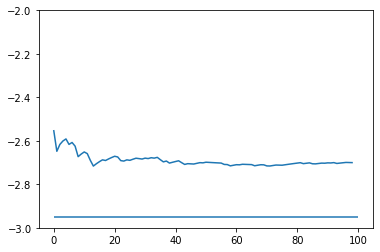

In [18]:
plt.plot(thermal_eng_METTS)
plt.hlines(thermal_eng,0,100)
plt.ylim(-3, -2)
plt.show()